In [ ]:
#| echo: false
import logging
import warnings

In [ ]:
#| echo: false
warnings.simplefilter('ignore')
logging.getLogger('statsforecast').setLevel(logging.ERROR)

# End to End Walkthrough

> Model training, evaluation and selection for multiple time series

:::{.callout-warning collapse="true"}
## Prerequesites
This Guide assumes basic familiarity with StatsForecast. For a minimal example visit the [Quick Start](./1_Getting_Started_short).
:::

Follow this article for a step to step guide on building a production-ready forecasting pipeline for multiple time series. 

During this guide you will gain familiary with the core `StatsForecast`class and some relevant methods like `StatsForecast.plot`, `StatsForecast.forecast` and `StatsForecast.cross_validation.`

We will use a classical benchmarking dataset from the M4 competition. The dataset includes time series from different domains like finance, economy and sales. In this example, we will use a subset of the Hourly dataset. 

We will model each time series individually. Forecasting at this level is also known as local forecasting. Therefore, you will train a series of models for every unique series and then select the best one. StatsForecast focuses on speed, simplicity, and scalability, which makes it ideal for this task.


**Outline:**

1. Install packages.
1. Read the data.
2. Explore the data.
3. Train many models for every unique combination of time series. 
4. Evaluate the model's performance using cross-validation. 
5. Select the best model for every unique time series.

:::{.callout-tip collapse=true}
## Not Covered in this guide

* Forecasting at scale using clusters on the cloud. 
    * [Forecast the M5 Dataset in 5min](../experiments/ETS_ray_m5) using Ray clusters.
    * [Forecast the M5 Dataset in 5min](../experiments/Prophet_spark_m5) using Spark clusters.
    * Learn how to predict [1M series in less than 30min](https://www.anyscale.com/blog/how-nixtla-uses-ray-to-accurately-predict-more-than-a-million-time-series).

* Training models on Multiple Seasonalities. 
    * Learn to use multiple seasonality in this [Electricity Load forecasting](../tutorials/ElectricityLoadForecasting) tutorial.

* Using external regressors or exogenous variables
    * Follow this tutorial to [include exogenous variables](../how-to-guides/Exogenous) like weather or holidays or static variables like category or family. 

* Comparing StatsForecast with other popular libraries.
    * You can reproduce our benchmarks [here](https://github.com/Nixtla/statsforecast/tree/main/experiments).
:::

## Install libraries

We assume you have StatsForecast already installed. Check this guide for instructions on [how to install StatsForecast](./0_Installation).

## Read the data

We will use pandas to read the M4 Hourly data set stored in a parquet file for efficiency. You can use ordinary pandas operations to read your data in other formats likes `.csv`. 

The input to StatsForecast is always a data frame in [long format](https://www.theanalysisfactor.com/wide-and-long-data/) with three columns: `unique_id`, `ds` and `y`:

* The `unique_id` (string, int or category) represents an identifier for the series. 

* The `ds` (datestamp or int) column should be either an integer indexing time or a datestampe ideally like YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

* The `y` (numeric) represents the measurement we wish to forecast. The target column needs to be renamed to `y` if it has a different column name.

This data set already satisfies the requirements.  

Depending on your internet connection, this step should take around 10 seconds. 

In [ ]:
import pandas as pd

In [ ]:
Y_df = pd.read_parquet('https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet')
Y_df.head()

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


This dataset contains 414 unique series with 900 observations on average. For this example and reproducibility's sake, we will select only 10 unique IDs and keep only the last week. Depending on your processing infrastructure feel free to select more or less series. 

:::{.callout-note}
Processing time is dependent on the available computing resources. Running this example with the complete dataset takes around 10 minutes in a c5d.24xlarge (96 cores) instance from AWS.
:::

In [ ]:
uids = Y_df['unique_id'].unique()[:10] # Select 10 ids to make the example faster
Y_df = Y_df.query('unique_id in @uids')
Y_df = Y_df.groupby('unique_id').tail(7 * 24) #Select last 7 days of data to make example faster

## Explore Data with the plot method

Plot some series using the `plot` method from the `StatsForecast` class. This method prints 8 random series from the dataset and is useful for basic EDA.

:::{.callout-note}
The `StatsForecast.plot` method uses Plotly as a defaul engine. You can change to MatPlotLib by setting `engine="matplotlib"`. 
:::

In [ ]:
from statsforecast import StatsForecast

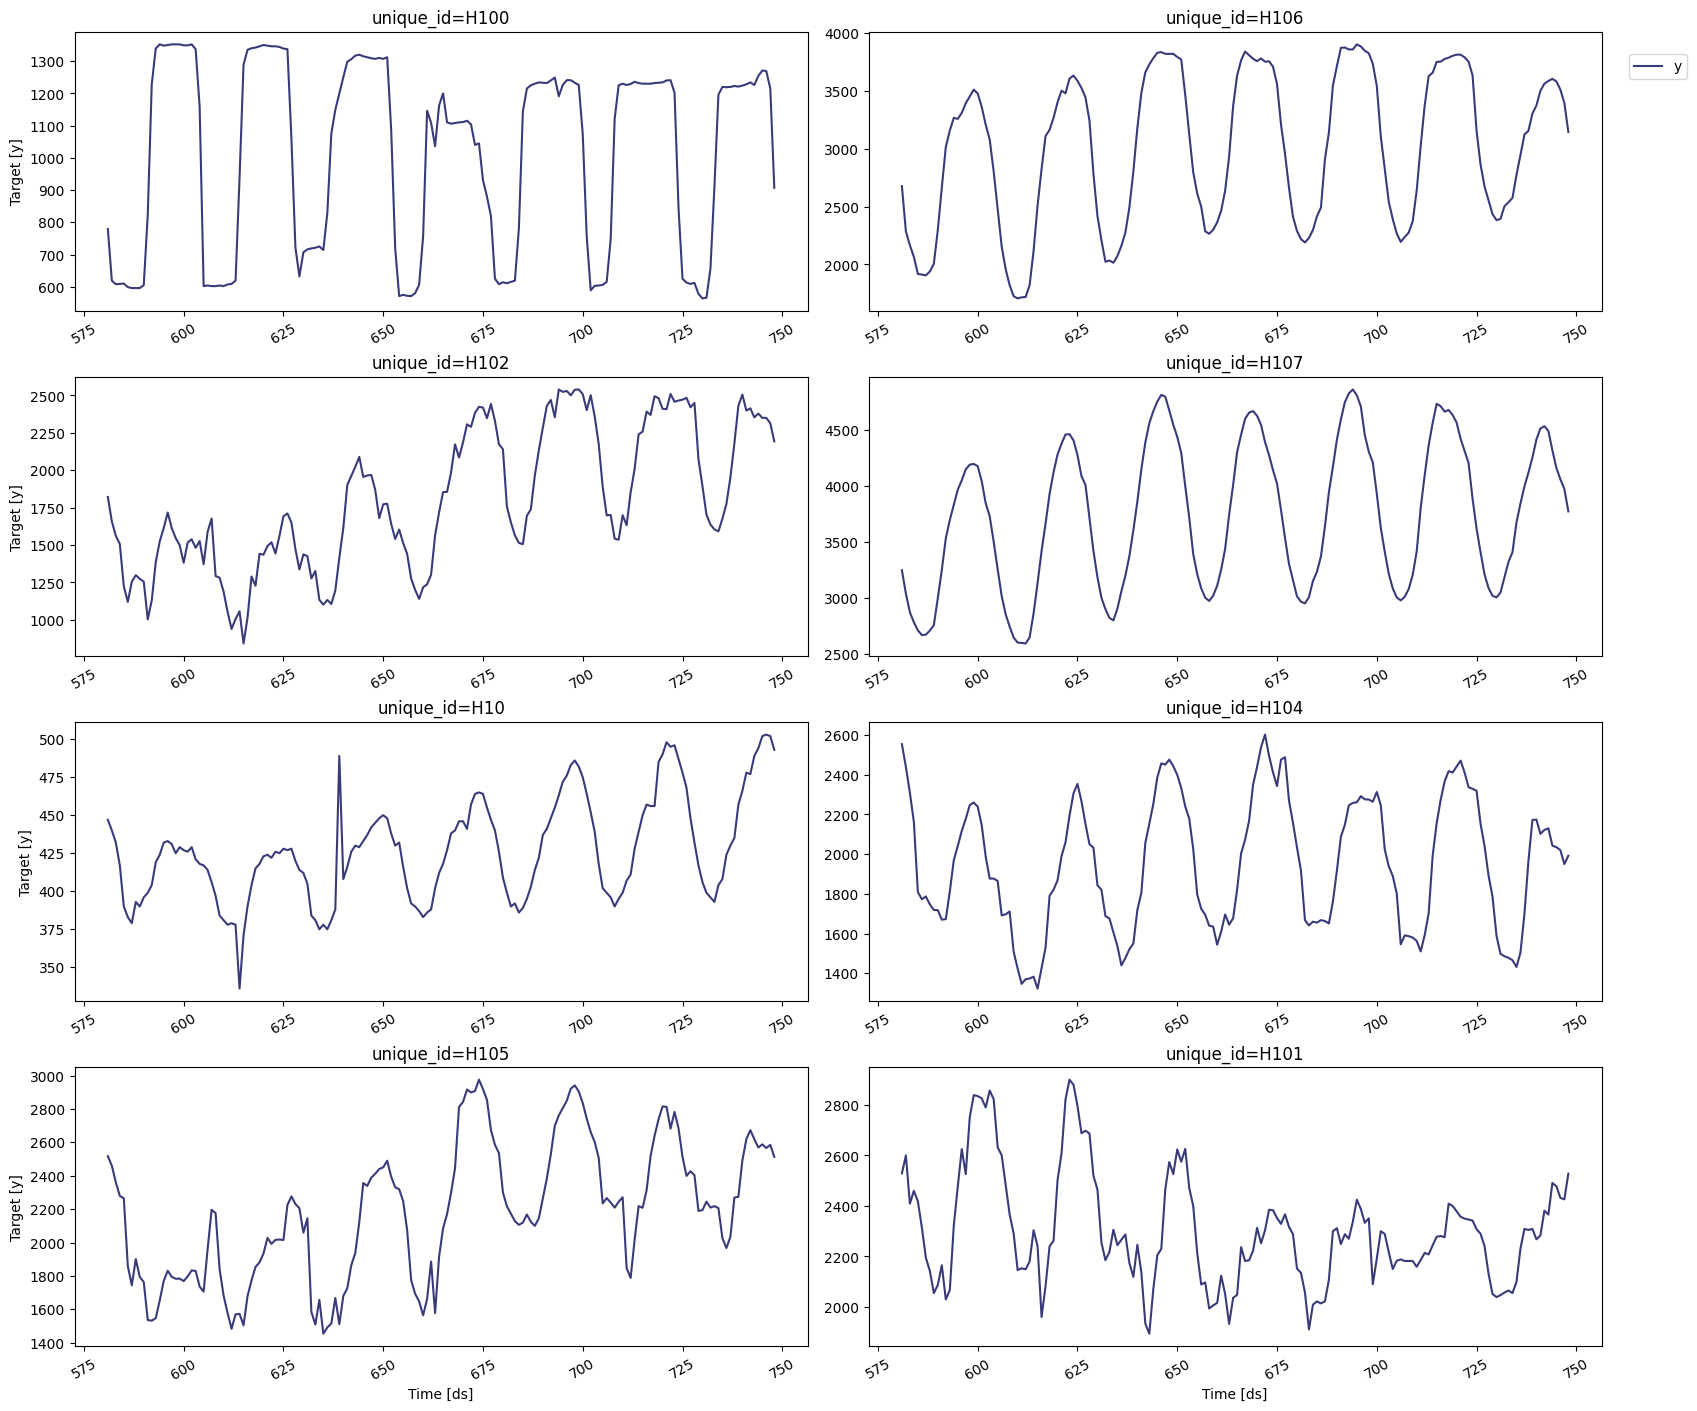

In [ ]:
StatsForecast.plot(Y_df)

## Train multiple models for many series

StatsForecast can train many models on many time series efficiently. 

Start by importing and instantiating the desired models. StatsForecast offers a wide variety of models grouped in the following categories:

*  **Auto Forecast:** Automatic forecasting tools search for the best parameters and select the best possible model for a series of time series. These tools are useful for large collections of univariate time series. Includes automatic versions of: Arima, ETS, Theta, CES.

* **Exponential Smoothing:**  Uses a weighted average of all past observations where the weights decrease exponentially into the past. Suitable for data with no clear trend or seasonality. Examples: SES, Holt's Winters, SSO.

* **Benchmark models:** classical models for establishing baselines. Examples: Mean, Naive, Random Walk

* **Intermittent or Sparse models:** suited for series with very few non-zero observations. Examples: CROSTON, ADIDA, IMAPA

* **Multiple Seasonalities:** suited for signals with more than one clear seasonality. Useful for low-frequency data like electricity and logs. Examples: MSTL. 

* **Theta Models:**  fit two theta lines to a deseasonalized time series, using different techniques to obtain and combine the two theta lines to produce the final forecasts. Examples: Theta, DynamicTheta

Here you can check the complete list of [models](../../src/core/models_intro) .

For this example we will use:

* `AutoARIMA`: Automatically selects the best ARIMA (AutoRegressive Integrated Moving Average) model using an information criterion. Ref: `AutoARIMA`.

* `HoltWinters`: triple exponential smoothing, Holt-Winters' method is an extension of exponential smoothing for series that contain both trend and seasonality. Ref: `HoltWinters`

* `SeasonalNaive`: Memory Efficient Seasonal Naive predictions. Ref: `SeasonalNaive`

* `HistoricAverage`: arthimetic mean. Ref: `HistoricAverage`.

* `DynamicOptimizedTheta`: The theta family of models has been shown to perform well in various datasets such as M3. Models the deseasonalized time series. Ref: `DynamicOptimizedTheta`.

Import and instantiate the models. Setting the `season_length` argument is sometimes tricky. This article on [Seasonal periods](https://robjhyndman.com/hyndsight/seasonal-periods/)) by the master, Rob Hyndmann, can be useful. 

In [ ]:
from statsforecast.models import (
    HoltWinters,
    CrostonClassic as Croston, 
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive
)

In [ ]:
# Create a list of models and instantiation parameters
models = [
    HoltWinters(),
    Croston(),
    SeasonalNaive(season_length=24),
    HistoricAverage(),
    DOT(season_length=24)
]

We fit the models by instantiating a new `StatsForecast` object with the following parameters:

* `models`: a list of models. Select the models you want from [models](../../src/core/models_intro)  and import them.

* `freq`: a string indicating the frequency of the data. (See [pandas available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).)

* `n_jobs`: n_jobs: int, number of jobs used in the parallel processing, use -1 for all cores.

* `fallback_model`: a model to be used if a model fails. 


Any settings are passed into the constructor. Then you call its fit method and pass in the historical data frame.


In [ ]:
# Instantiate StatsForecast class as sf
sf = StatsForecast( 
    models=models,
    freq=1, 
    fallback_model = SeasonalNaive(season_length=7),
    n_jobs=-1,
)

:::{.callout-note}
StatsForecast achieves its blazing speed using JIT compiling through Numba. The first time you call the statsforecast class, the fit method should take around 5 seconds. The second time -once Numba compiled your settings- it should take less than 0.2s. 
:::


The `forecast` method takes two arguments: forecasts next `h` (horizon) and `level`.

* `h` (int): represents the forecast h steps into the future. In this case, 12 months ahead. 

* `level` (list of floats): this optional parameter is used for probabilistic forecasting. Set the `level` (or confidence percentile) of your prediction interval. For example, `level=[90]` means that the model expects the real value to be inside that interval 90% of the times. 

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals. Depending on your computer, this step should take around 1min. (If you want to speed things up to a couple of seconds, remove the AutoModels like ARIMA and Theta)

:::{.callout-note}
The `forecast` method is compatible with distributed clusters, so it does not store any model parameters. If you want to store parameters for every model you can use the `fit` and `predict` methods. However, those methods are not defined for distrubed engines like Spark, Ray or Dask.
:::

In [ ]:
forecasts_df = sf.forecast(df=Y_df, h=48, level=[90])
forecasts_df.head()

,unique_id,ds,HoltWinters,HoltWinters-lo-90,HoltWinters-hi-90,CrostonClassic,CrostonClassic-lo-90,CrostonClassic-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,HistoricAverage,HistoricAverage-lo-90,HistoricAverage-hi-90,DynamicOptimizedTheta,DynamicOptimizedTheta-lo-90,DynamicOptimizedTheta-hi-90
0,H1,749,829.0,422.549268,1235.450732,829.0,422.549268,1235.450732,635.0,566.036734,703.963266,660.982143,398.037761,923.926524,592.701851,577.677280,611.652639
1,H1,750,807.0,400.549268,1213.450732,807.0,400.549268,1213.450732,572.0,503.036734,640.963266,660.982143,398.037761,923.926524,525.589116,505.449755,546.621805
2,H1,751,785.0,378.549268,1191.450732,785.0,378.549268,1191.450732,532.0,463.036734,600.963266,660.982143,398.037761,923.926524,489.251814,462.072871,512.424116
3,H1,752,756.0,349.549268,1162.450732,756.0,349.549268,1162.450732,493.0,424.036734,561.963266,660.982143,398.037761,923.926524,456.195032,430.554302,478.260963
4,H1,753,719.0,312.549268,1125.450732,719.0,312.549268,1125.450732,477.0,408.036734,545.963266,660.982143,398.037761,923.926524,436.290514,411.051232,461.815932


Plot the results of 8 random series using the `StatsForecast.plot` method. 

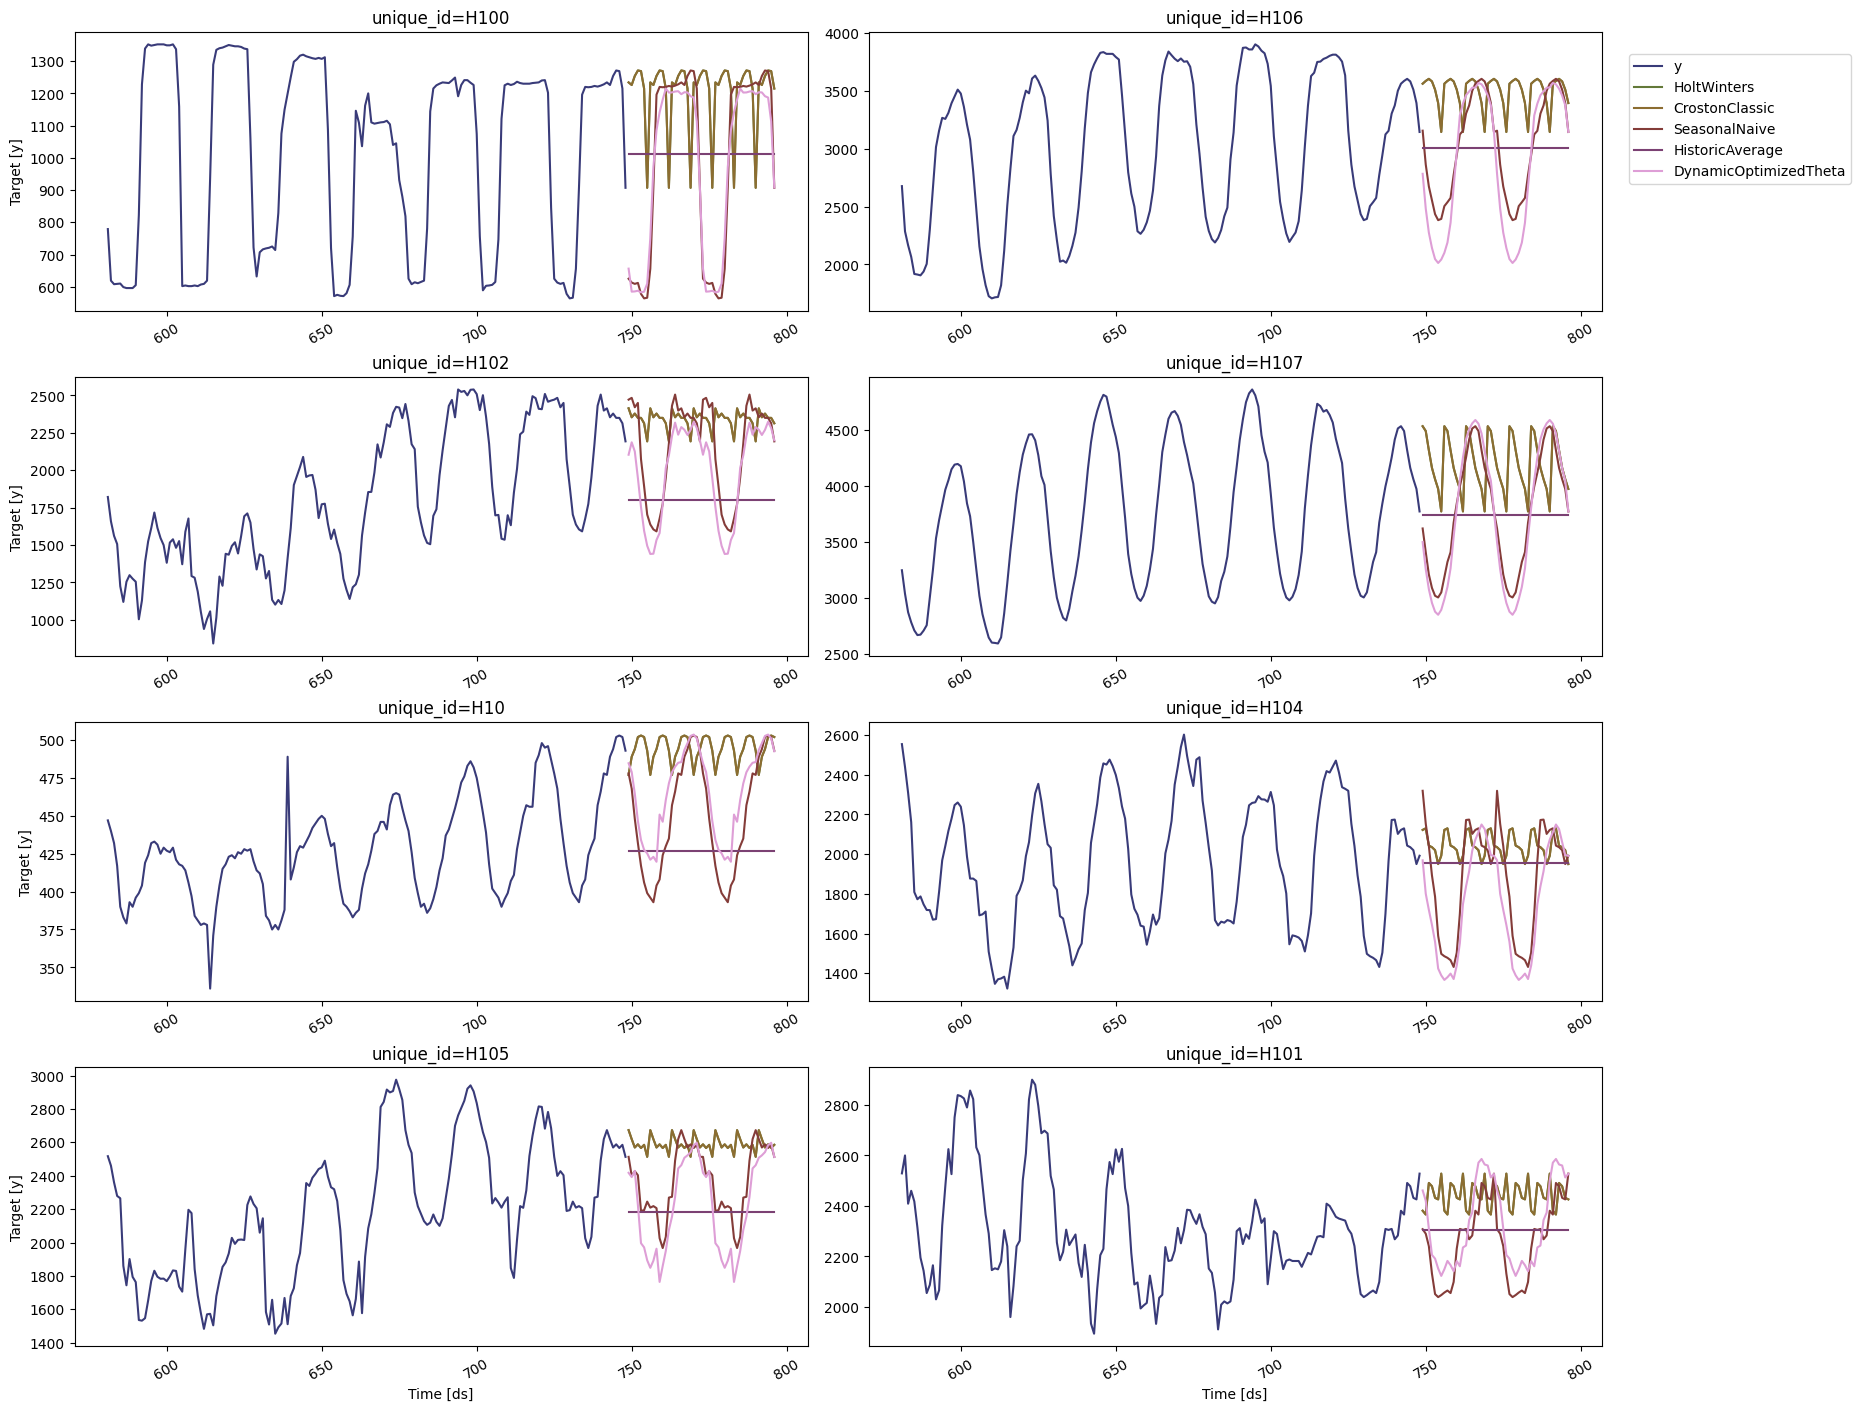

In [ ]:
sf.plot(Y_df,forecasts_df)

The `StatsForecast.plot` allows for further customization. For example, plot the results of the different models and unique ids. 

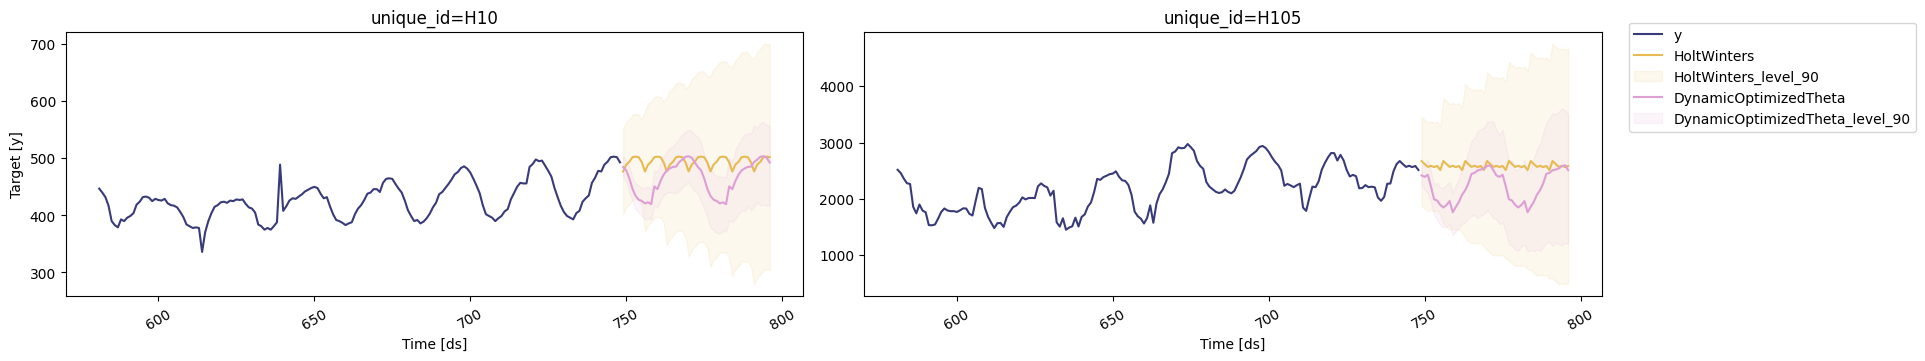

In [ ]:
# Plot to unique_ids and some selected models
sf.plot(Y_df, forecasts_df, models=["HoltWinters","DynamicOptimizedTheta"], unique_ids=["H10", "H105"], level=[90])

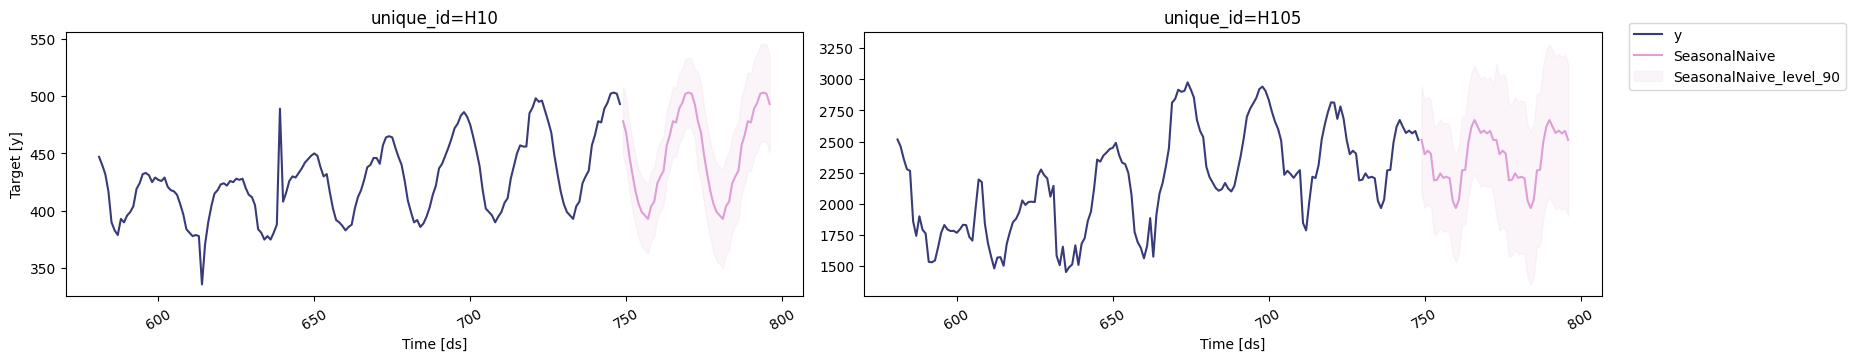

In [ ]:
# Explore other models 
sf.plot(Y_df, forecasts_df, models=["SeasonalNaive"], unique_ids=["H10", "H105"], level=[90])

## Evaluate the model's performance


In previous steps, we've taken our historical data to predict the future. However, to asses its accuracy we would also like to know how the model would have performed in the past. To assess the accuracy and robustness of your models on your data perform Cross-Validation.

With time series data, **Cross Validation** is done by defining a sliding window across the historical data and predicting the period following it. This form of cross-validation allows us to arrive at a better estimation of our model's predictive abilities across a wider range of temporal instances while also keeping the data in the training set contiguous as is required by our models.

The following graph depicts such a Cross Validation Strategy:

![](https://raw.githubusercontent.com/Nixtla/statsforecast/main/nbs/imgs/ChainedWindows.gif)

Cross-validation of time series models is considered a best practice but most implementations are very slow. The statsforecast library implements cross-validation as a distributed operation, making the process less time-consuming to perform. If you have big datasets you can also perform Cross Validation in a distributed cluster using Ray, Dask or Spark. 

In this case, we want to evaluate the performance of each model for the last 2 days (n_windows=2), forecasting every second day (step_size=48).  Depending on your computer, this step should take around 1 min. 

:::{.callout-tip}
Setting `n_windows=1` mirrors a traditional train-test split with our historical data serving as the training set and the last 48 hours serving as the testing set. 
:::

The `cross_validation` method from the `StatsForecast` class takes the following arguments.

* `df`: training data frame 

* `h` (int): represents h steps into the future that are being forecasted. In this case, 24 hours ahead. 

* `step_size` (int): step size between each window. In other words: how often do you want to run the forecasting processes. 

* `n_windows`(int): number of windows used for cross validation. In other words: what number of forecasting processes in the past do you want to evaluate.


In [ ]:
cv_df = sf.cross_validation(
    df=Y_df,
    h=24,
    step_size=24,
    n_windows=2
)

The `cv_df` object is a new data frame that includes the following columns:

* `unique_id`: series identifier

* `ds`: datestamp or temporal index 

* `cutoff`: the last datestamp or temporal index for the `n_windows.` If `n_windows=1`, then one unique cuttoff value, if `n_windows=2` then two unique cutoff values. 

* `y`: true value 

* `"model"`: columns with the model's name and fitted value. 


In [ ]:
cv_df.head()

,unique_id,ds,cutoff,y,HoltWinters,CrostonClassic,SeasonalNaive,HistoricAverage,DynamicOptimizedTheta
0,H1,701,700,619.0,847.0,742.668748,691.0,661.675,612.767504
1,H1,702,700,565.0,820.0,742.668748,618.0,661.675,536.846278
2,H1,703,700,532.0,790.0,742.668748,563.0,661.675,497.824286
3,H1,704,700,495.0,784.0,742.668748,529.0,661.675,464.723219
4,H1,705,700,481.0,752.0,742.668748,504.0,661.675,440.972336


Next, we will evaluate the performance of every model for every series using common error metrics like Mean Absolute Error (MAE) or Mean Square Error (MSE)
Define a utility function to evaluate different error metrics for the cross validation data frame. 

First import the desired error metrics from `utilsforecast.losses`. Then define a utility function that takes a cross-validation data frame as a metric and returns an evaluation data frame with the average of the error metric for every unique id and fitted model and all cutoffs. 

In [ ]:
from utilsforecast.losses import mse

In [ ]:
def evaluate_cv(df, metric):
    models = df.columns.drop(['unique_id', 'ds', 'y', 'cutoff']).tolist()
    evals = metric(df, models=models)
    evals['best_model'] = evals[models].idxmin(axis=1)
    return evals

:::{.callout-warning}
You can also use Mean Average Percentage Error (MAPE), however for granular forecasts, MAPE values are extremely [hard to judge](https://blog.blueyonder.com/mean-absolute-percentage-error-mape-has-served-its-duty-and-should-now-retire/) and not useful to assess forecasting quality.
:::

Create the data frame with the results of the evaluation of your cross-validation data frame using a Mean Squared Error metric. 

In [ ]:
evaluation_df = evaluate_cv(cv_df, mse)
evaluation_df.head()

,unique_id,HoltWinters,CrostonClassic,SeasonalNaive,HistoricAverage,DynamicOptimizedTheta,best_model
0,H1,44888.020833,28038.733985,1422.666667,20927.664488,1296.333977,DynamicOptimizedTheta
1,H10,2812.916667,1483.483839,96.895833,1980.367543,379.621134,SeasonalNaive
2,H100,121625.375000,91945.139237,12019.000000,78491.191439,21699.649325,SeasonalNaive
3,H101,28453.395833,16183.634340,10944.458333,18208.409800,63698.077266,SeasonalNaive
4,H102,232924.854167,132655.309136,12699.895833,309110.475212,31393.535274,SeasonalNaive


Create a summary table with a model column and the number of series where that model performs best. In this case, the Arima and Seasonal Naive are the best models for 10 series and the Theta model should be used for two.

In [ ]:
evaluation_df['best_model'].value_counts().to_frame().reset_index()

,best_model,count
0,SeasonalNaive,6
1,DynamicOptimizedTheta,4


You can further explore your results by plotting the unique_ids where a specific model wins.

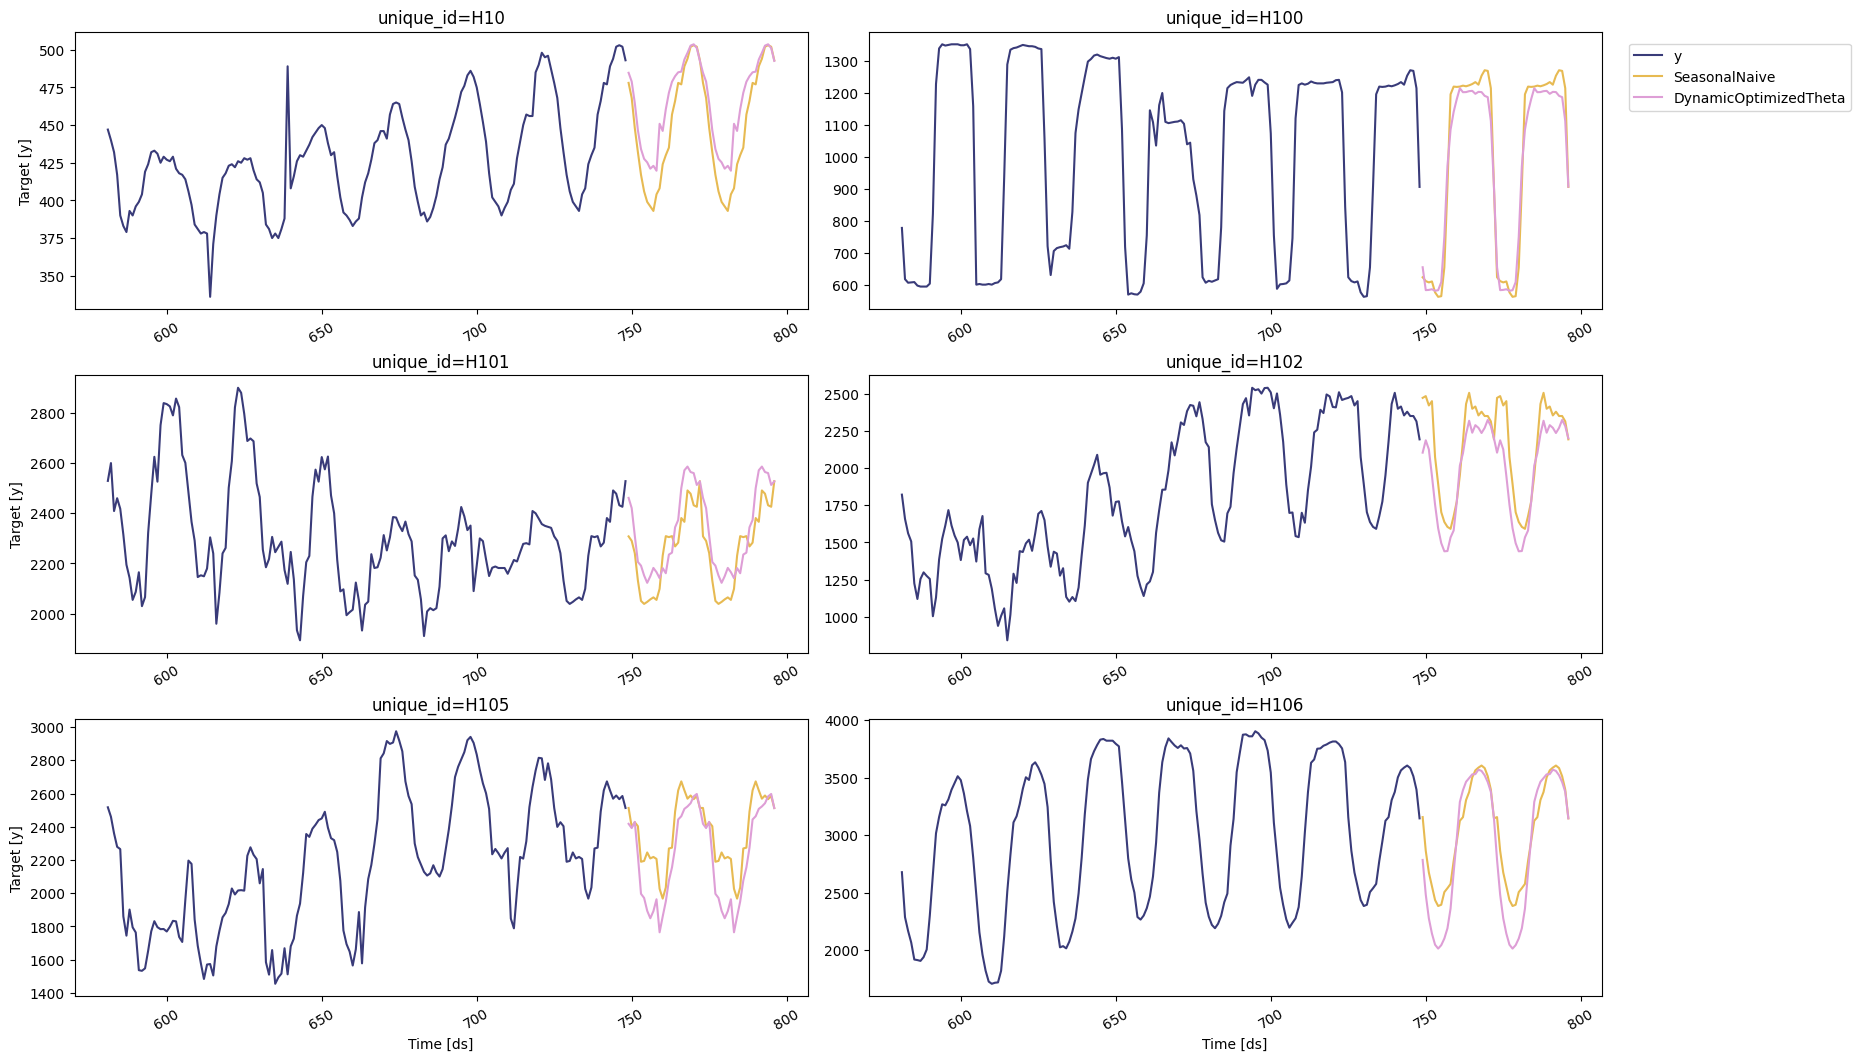

In [ ]:
seasonal_ids = evaluation_df.query('best_model == "SeasonalNaive"')['unique_id']
sf.plot(Y_df,forecasts_df, unique_ids=seasonal_ids, models=["SeasonalNaive","DynamicOptimizedTheta"])

## Select the best model for every unique series

Define a utility function that takes your forecast's data frame with the predictions and the evaluation data frame and returns a data frame with the best possible forecast for every unique_id.

In [ ]:
def get_best_model_forecast(forecasts_df, evaluation_df):
    with_best = forecasts_df.merge(evaluation_df[['unique_id', 'best_model']])
    res = with_best[['unique_id', 'ds']].copy()
    for suffix in ('', '-lo-90', '-hi-90'):
        res[f'best_model{suffix}'] = with_best.apply(lambda row: row[row['best_model'] + suffix], axis=1)
    return res

Create your production-ready data frame with the best forecast for every unique_id.

In [ ]:
prod_forecasts_df = get_best_model_forecast(forecasts_df, evaluation_df)
prod_forecasts_df.head()

,unique_id,ds,best_model,best_model-lo-90,best_model-hi-90
0,H1,749,592.701851,577.677280,611.652639
1,H1,750,525.589116,505.449755,546.621805
2,H1,751,489.251814,462.072871,512.424116
3,H1,752,456.195032,430.554302,478.260963
4,H1,753,436.290514,411.051232,461.815932


Plot the results. 

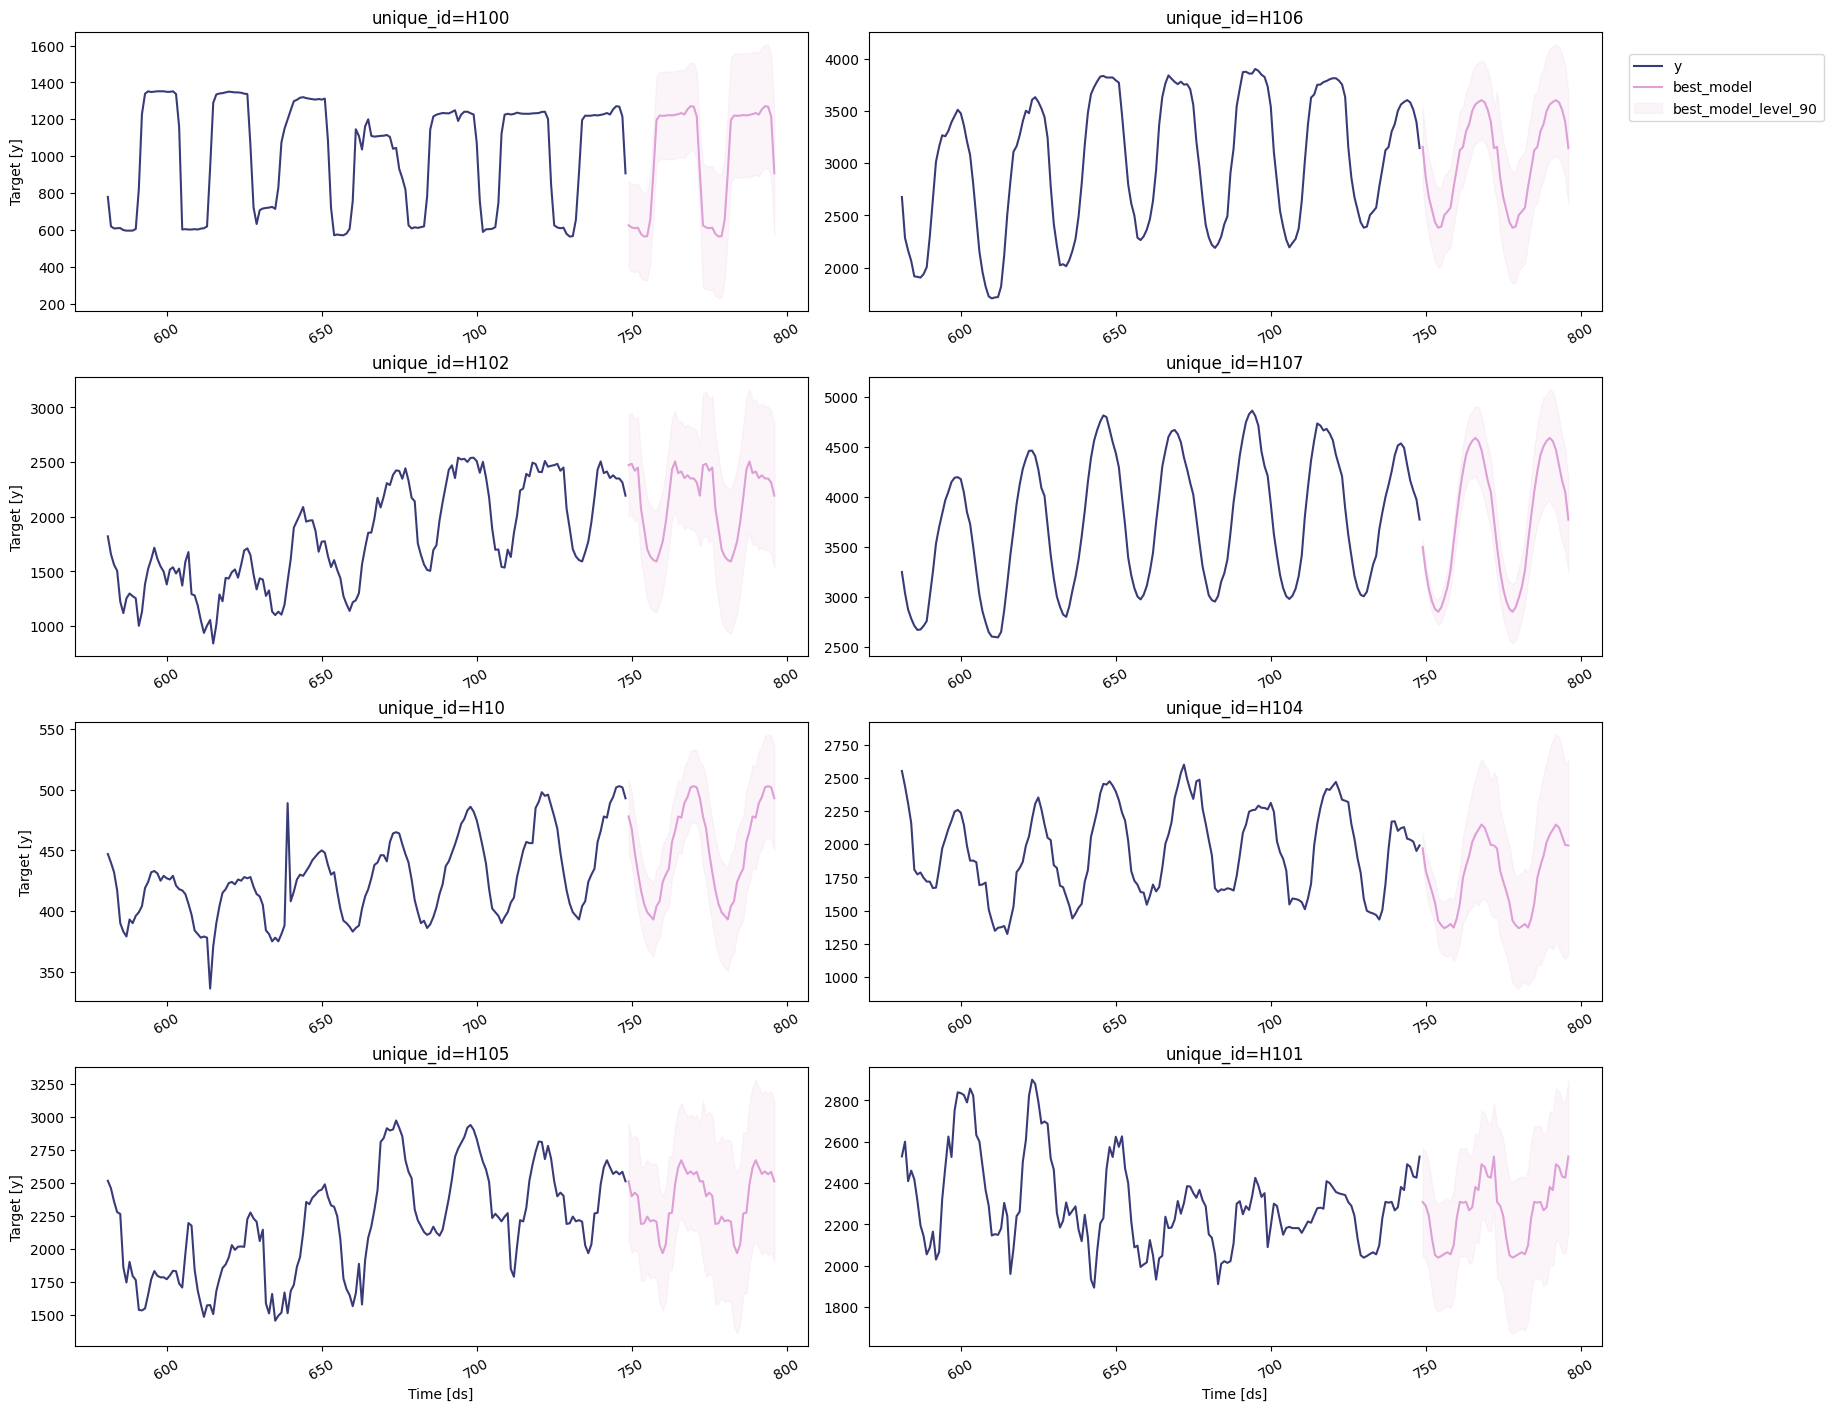

In [ ]:
sf.plot(Y_df, prod_forecasts_df, level=[90])